This is a project to build a model that diagnoses eye conditions based on images of the anterior of the eye.
For this version we have a dataset with five different conditions, Cataract, Conjunctivitis, Eyelid, Normal and Uveitis.
For this model we are using a Sequential Convolutional Neural Network for this project.

In [1]:
# Step 1: Import Necessary Libraries
# In order to build the CNN, I need TensorFlow for the model, NumPy for data handling, cv2 for image processing, os for file manipulation,
# and Matplotlib for visualization.

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Output version of TensorFlow being used
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.16.2


In [2]:
# Step 2a: Create the classes for the images based on the folder names with different conditions in each folder

import re

# Set path for the director of the data set to be used
DATA_DIR = '/Users/aresbandebo/PycharmProjects/Eye_CNN_Testing/Dataset_Eye_Diseases_Classification'

# Set the desired image dimensions for resizing.
IMG_HEIGHT = 224
IMG_WIDTH = 224

def create_classes_from_dirs(target_path):
    """
    Scans a target path and dynamically creates Python classes based on the names
    of the directories found within it.

    Args:
        target_path (str): The absolute or relative path to the directory to scan.

    Returns:
        dict: A dictionary containing the names and class objects that were created.
              Returns an empty dictionary if the path does not exist or contains no directories.
    """
    print(f"Attempting to scan for directories in: '{target_path}'")

    # --- 1. Validate the path ---
    if not os.path.isdir(target_path):
        print(f"\nError: The specified path does not exist or is not a directory.")
        print("Please make sure the path is correct and accessible.")
        return {}

    created_classes = {}

    # --- 2. Find all sub-directories ---
    try:
        # Get a list of all entries in the target_path and filter for directories
        dir_names = [name for name in os.listdir(target_path)
                     if os.path.isdir(os.path.join(target_path, name))]
    except OSError as e:
        print(f"\nError: Could not access the path. Reason: {e}")
        return {}

    if not dir_names:
        print("\nNo sub-directories were found in the specified path.")
        return {}

    print(f"\nFound {len(dir_names)} directories. Creating corresponding classes...")

    # --- 3. Create a class for each directory ---
    for dir_name in dir_names:
        # Sanitize the directory name to make it a valid Python class name
        # (e.g., "diabetic retinopathy" -> "Diabetic_retinopathy")
        class_name = re.sub(r'[^0-9a-zA-Z_]', '_', dir_name).capitalize()

        # If the first character is not a letter, prepend 'C' for 'Class'
        if not class_name[0].isalpha():
            class_name = 'C' + class_name

        # Dynamically create the class using the type() function
        # Format: type(ClassName, (BaseClasses,), {attributes_and_methods})
        new_class = type(class_name, (object,), {
            '__doc__': f'Dynamically generated class from the "{dir_name}" directory.',
            'source_directory': dir_name,
            'file_count': len(os.listdir(os.path.join(target_path, dir_name)))
        })

        # Add the new class to the global scope of this script, making it accessible
        globals()[class_name] = new_class
        created_classes[class_name] = new_class
        print(f"- Created class: {class_name}")

    return created_classes

# --- Main execution block ---
if __name__ == "__main__":

    # Generate the classes
    dynamic_classes = create_classes_from_dirs(DATA_DIR)

    # --- Verification Step ---
    # This section demonstrates how to use the dynamically created classes.
    if dynamic_classes:
        print("\n--- Verification ---")
        print("The classes have been created and are now available for use.")
        print("Let's inspect the first class that was created:\n")

        # Get the name of the first class from the dictionary
        first_class_name = list(dynamic_classes.keys())[0]

        # Access the class from the global scope using its name
        FirstClass = globals()[first_class_name]

        # Create an instance of the class
        instance = FirstClass()

        # Print some information about the instance and its class
        print(f"Class Name: {first_class_name}")
        print(f"Instance created: {instance}")
        print(f"Instance type: {type(instance)}")
        print(f"Class docstring: {instance.__doc__}")
        print(f"Original directory name: '{instance.source_directory}'")
        print(f"Number of files in directory: {instance.file_count}")

    if dynamic_classes:
        class_names = list(dynamic_classes.keys())
        class_names.sort()
        print("\n--- List of All Class Names ---")
        print("A list called 'class_names' has been created with the names of all generated classes.")
        print(class_names)



Attempting to scan for directories in: '/Users/aresbandebo/PycharmProjects/Eye_CNN_Testing/Dataset_Eye_Diseases_Classification'

Found 5 directories. Creating corresponding classes...
- Created class: Cataract
- Created class: Uveitis
- Created class: Conjunctivitis
- Created class: Eyelid
- Created class: Normal

--- Verification ---
The classes have been created and are now available for use.
Let's inspect the first class that was created:

Class Name: Cataract
Instance created: <__main__.Cataract object at 0x316054290>
Instance type: <class '__main__.Cataract'>
Class docstring: Dynamically generated class from the "Cataract" directory.
Original directory name: 'Cataract'
Number of files in directory: 544

--- List of All Class Names ---
A list called 'class_names' has been created with the names of all generated classes.
['Cataract', 'Conjunctivitis', 'Eyelid', 'Normal', 'Uveitis']


In [4]:
# Step 2b: Import Images from a data set where the different eye conditions have pictures in different directories.



def load_data(DATA_DIR):
    """
    Loads images and their corresponding labels from a directory.

    Args:
        data_dir (str): The path to the directory containing subdirectories
                        of images, where each subdirectory name is a class label.

    Returns:
        tuple: A tuple containing two lists:
               - images (list): A list of image data as numpy arrays.
               - labels (list): A list of corresponding string labels.
    """
    images = []
    labels = []


    # Get the class names (folder names)

    for class_name in class_names:
        class_path = os.path.join(DATA_DIR, class_name)

        # Skip files that are not directories
        if not os.path.isdir(class_path):
            continue

        print(f"Loading images from: {class_name}")
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)

            try:
                # Read the image using OpenCV (which loads in BGR format)
                image_bgr = cv2.imread(image_path)

                # --- IMPORTANT COLOR CORRECTION ---
                # Matplotlib expects images in RGB format. We must convert from BGR to RGB.
                # Failure to do this will result in incorrect colors (the blueish tint).
                image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

                # Resize the image to a consistent size
                resized_image_rgb = cv2.resize(image_rgb, (IMG_WIDTH, IMG_HEIGHT))

                # Append the correctly colored, resized image and its label
                images.append(resized_image_rgb)
                labels.append(class_name)
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")

    return images, labels


In [5]:
# Step 3: Loading the images from the data directory and split the images into a training data set, a validation data set and a testing data set


if __name__ == "__main__":
    # 1. Validate the DATA_DIR path
    if DATA_DIR == 'path/to/your/dataset':
        print("="*50)
        print("ERROR: Please update the 'DATA_DIR' variable in the script.")
        print("You need to change the default value to the actual path of your dataset.")
        print("="*50)
    elif not os.path.exists(DATA_DIR):
        print("="*50)
        print(f"ERROR: The path specified in DATA_DIR does not exist.")
        print(f"Path provided: '{DATA_DIR}'")
        print(f"Current working directory is: '{os.getcwd()}'")
        print("Please double-check that the path is correct and the script has permission to access it.")
        print("="*50)
    elif not os.path.isdir(DATA_DIR):
        print("="*50)
        print(f"ERROR: The path specified in DATA_DIR is not a directory.")
        print(f"Path provided: '{DATA_DIR}'")
        print("Please ensure DATA_DIR points to the folder containing your class subfolders.")
        print("="*50)
    else:
        # 2. Load the images and labels
        images, labels = load_data(DATA_DIR)

        # 3. Convert lists to NumPy arrays
        images = np.array(images, dtype='float32')
        labels = np.array(labels)

        # 4. Normalize image data
        # Scale pixel values from [0, 255] to [0, 1]
        images /= 255.0

        # 5. Encode string labels to integers
        label_encoder = LabelEncoder()
        integer_labels = label_encoder.fit_transform(labels)

        # 6. One-hot encode the integer labels
        # This is necessary for categorical cross-entropy loss function
        num_classes = len(np.unique(integer_labels))
        categorical_labels = to_categorical(integer_labels, num_classes=num_classes)

        # 7. Split the data into training, validation, and testing sets
        # First, split into a temporary training set (80%) and a testing set (20%)
        (X_train_temp, X_test, y_train_temp, y_test) = train_test_split(
            images, categorical_labels, test_size=0.20, stratify=categorical_labels, random_state=42
        )
        print(y_train_temp, categorical_labels)
        # 8. Split the temporary training set into the final training set (75% of 80% = 60%)
        # and a validation set (25% of 80% = 20%)
        (X_train, X_val, y_train, y_val) = train_test_split(
            X_train_temp, y_train_temp, test_size=0.25, stratify=y_train_temp, random_state=42
        )

        # --- Output the results ---
        print("\n--- Data Preprocessing Summary ---")
        print(f"Total images loaded: {len(images)}")
        print(f"Number of classes: {num_classes}")
        print(f"Shape of training data (images): {X_train.shape}")
        print(f"Shape of training data (labels): {y_train.shape}")
        print(f"Shape of validation data (images): {X_val.shape}")
        print(f"Shape of validation data (labels): {y_val.shape}")
        print(f"Shape of testing data (images): {X_test.shape}")
        print(f"Shape of testing data (labels): {y_test.shape}")
        print("\nOriginal Labels:", label_encoder.classes_)
        print("Encoded Labels Mapping:")
        for i, class_name in enumerate(label_encoder.classes_):
            print(f"  {class_name} -> {i}")

        print("\nThe Data is now ready for training the model!")


        # --- 9. Verify the data ---
        print("\n--- Data Verification ---")
        total_samples = len(images)
        print(f"Training set:   {len(X_train)} samples ({len(X_train)/total_samples:.2%})")
        print(f"Validation set: {len(X_val)} samples ({len(X_val)/total_samples:.2%})")
        print(f"Test set:       {len(X_test)} samples ({len(X_test)/total_samples:.2%})")

Loading images from: Cataract
Loading images from: Conjunctivitis
Loading images from: Eyelid
Loading images from: Normal
Loading images from: Uveitis
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]] [[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]

--- Data Preprocessing Summary ---
Total images loaded: 2282
Number of classes: 5
Shape of training data (images): (1368, 224, 224, 3)
Shape of training data (labels): (1368, 5)
Shape of validation data (images): (457, 224, 224, 3)
Shape of validation data (labels): (457, 5)
Shape of testing data (images): (457, 224, 224, 3)
Shape of testing data (labels): (457, 5)

Original Labels: ['Cataract' 'Conjunctivitis' 'Eyelid' 'Normal' 'Uveitis']
Encoded Labels Mapping:
  Cataract -> 0
  Conjunctivitis -> 1
  Eyelid -> 2
  Normal -> 3
  Uveitis -> 4

The Data is now ready for training the model!

--- Data Verification -


Displaying a sample of training images...


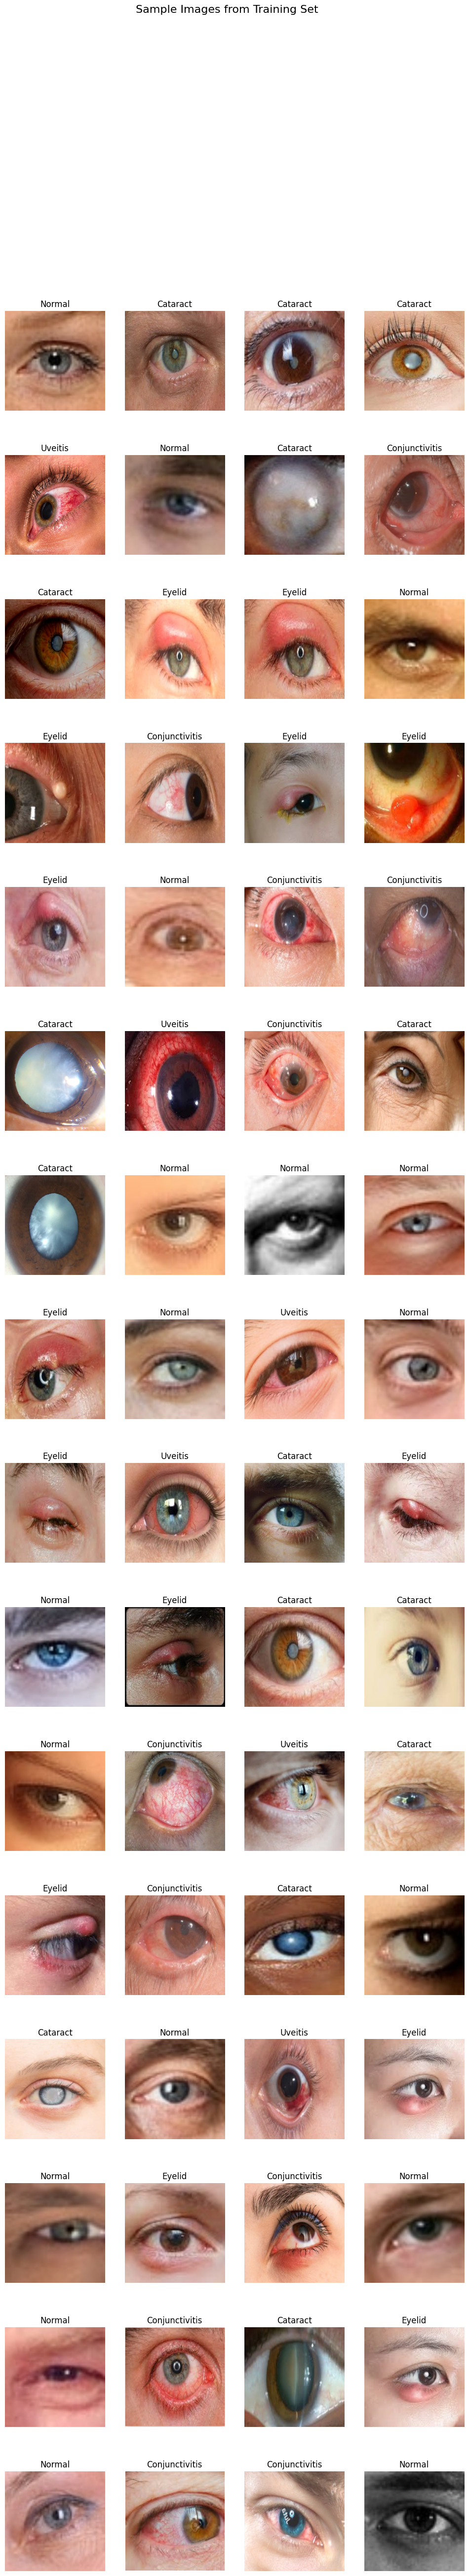

In [7]:
# Step 4: Display sample images
def show_sample_images(sample_images, sample_labels, class_names_map):
    plt.figure(figsize=(12, 60))
    for i in range(min(64, len(sample_images)-1)): # Show up to 240 images
        plt.subplot(16, 4, i + 1)
        plt.imshow(sample_images[i])
        # Convert one-hot encoded label back to integer, then to class name
        label_index = np.argmax(sample_labels[i])
        plt.title(class_names_map[label_index])
        plt.axis("off")
    plt.suptitle("Sample Images from Training Set", fontsize=16)
    plt.show()

# Display some images from the training set to verify
print("\nDisplaying a sample of training images...")
show_sample_images(X_train, y_train, label_encoder.classes_)

In [8]:
# Step 5: Build the Convolutional Neural Network (CNN) Model
# We now specify (32, 32, 3) to account for the 32x32 pixel size and 3 color channels.

model = models.Sequential()
# Layer 1: Convolutional layer. 32 filters, 3x3 kernel size.
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
# Layer 2: Pooling layer.
model.add(layers.MaxPooling2D((2, 2)))
# Layer 3: Another Convolutional layer. We increase filters to 64.
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# Layer 4: Another Pooling layer.
model.add(layers.MaxPooling2D((2, 2)))
# Layer 5: A final Convolutional layer.
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Now, let's add the final Dense (fully connected) layers for classification.
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_classes)) # Output layer with 5 neurons for our 5 classes

# Let's see the model summary.
model.summary()



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 173056)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    11,075,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,132,293 (42.47 MB)

 Trainable params: 11,132,293 (42.47 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Step 6: Compile the Model
# We configure the model for training.

model.compile(optimizer='adam',
              # For this loss function, it's good practice to set from_logits=True
              # because our model's output layer doesn't have a softmax activation function.
              # This can sometimes be more numerically stable.
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



In [10]:
    # Step 7: Train the Model
# We train for 10 epochs

print("\nStarting model training...")
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_val, y_val))
print("Model training finished.")




Starting model training...
Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 303ms/step - accuracy: 0.3028 - loss: 3.7192 - val_accuracy: 0.5011 - val_loss: 1.2199
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 300ms/step - accuracy: 0.5784 - loss: 1.0895 - val_accuracy: 0.6740 - val_loss: 0.9191
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 299ms/step - accuracy: 0.6494 - loss: 0.9796 - val_accuracy: 0.6586 - val_loss: 1.0160
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 302ms/step - accuracy: 0.7586 - loss: 0.6716 - val_accuracy: 0.6652 - val_loss: 0.8294
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 303ms/step - accuracy: 0.8622 - loss: 0.4160 - val_accuracy: 0.7177 - val_loss: 0.8533
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 308ms/step - accuracy: 0.8994 - loss: 0.3020 - val_accuracy: 0.7549 - val_loss: 0.8276
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 309ms/step - accuracy: 0.9313 - loss: 0.1834 - val_accuracy: 0.7549 - val_loss: 0.8723
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 307ms/step - accuracy: 0.96

In [11]:
# Step 8: Evaluate the Model
# Check the final performance on the test set.

print("\nEvaluating model on the test dataset...")
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
print(f'\nTest accuracy: {test_acc:.4f}')
print(f'Test loss: {test_loss:.4f}')

# Note: My target is to get 70% accuracy or more on CIFAR-10.




Evaluating model on the test dataset...
15/15 - 1s - 73ms/step - accuracy: 0.7549 - loss: 1.1305

Test accuracy: 0.7549
Test loss: 1.1305


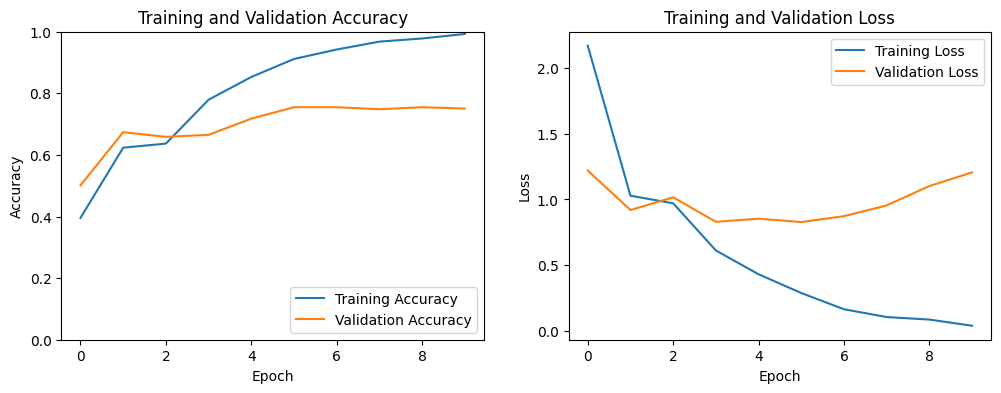

In [12]:
# Step 9: Visualize Training Results
# Plotting the history helps us understand the training process.

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')

plt.show()



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


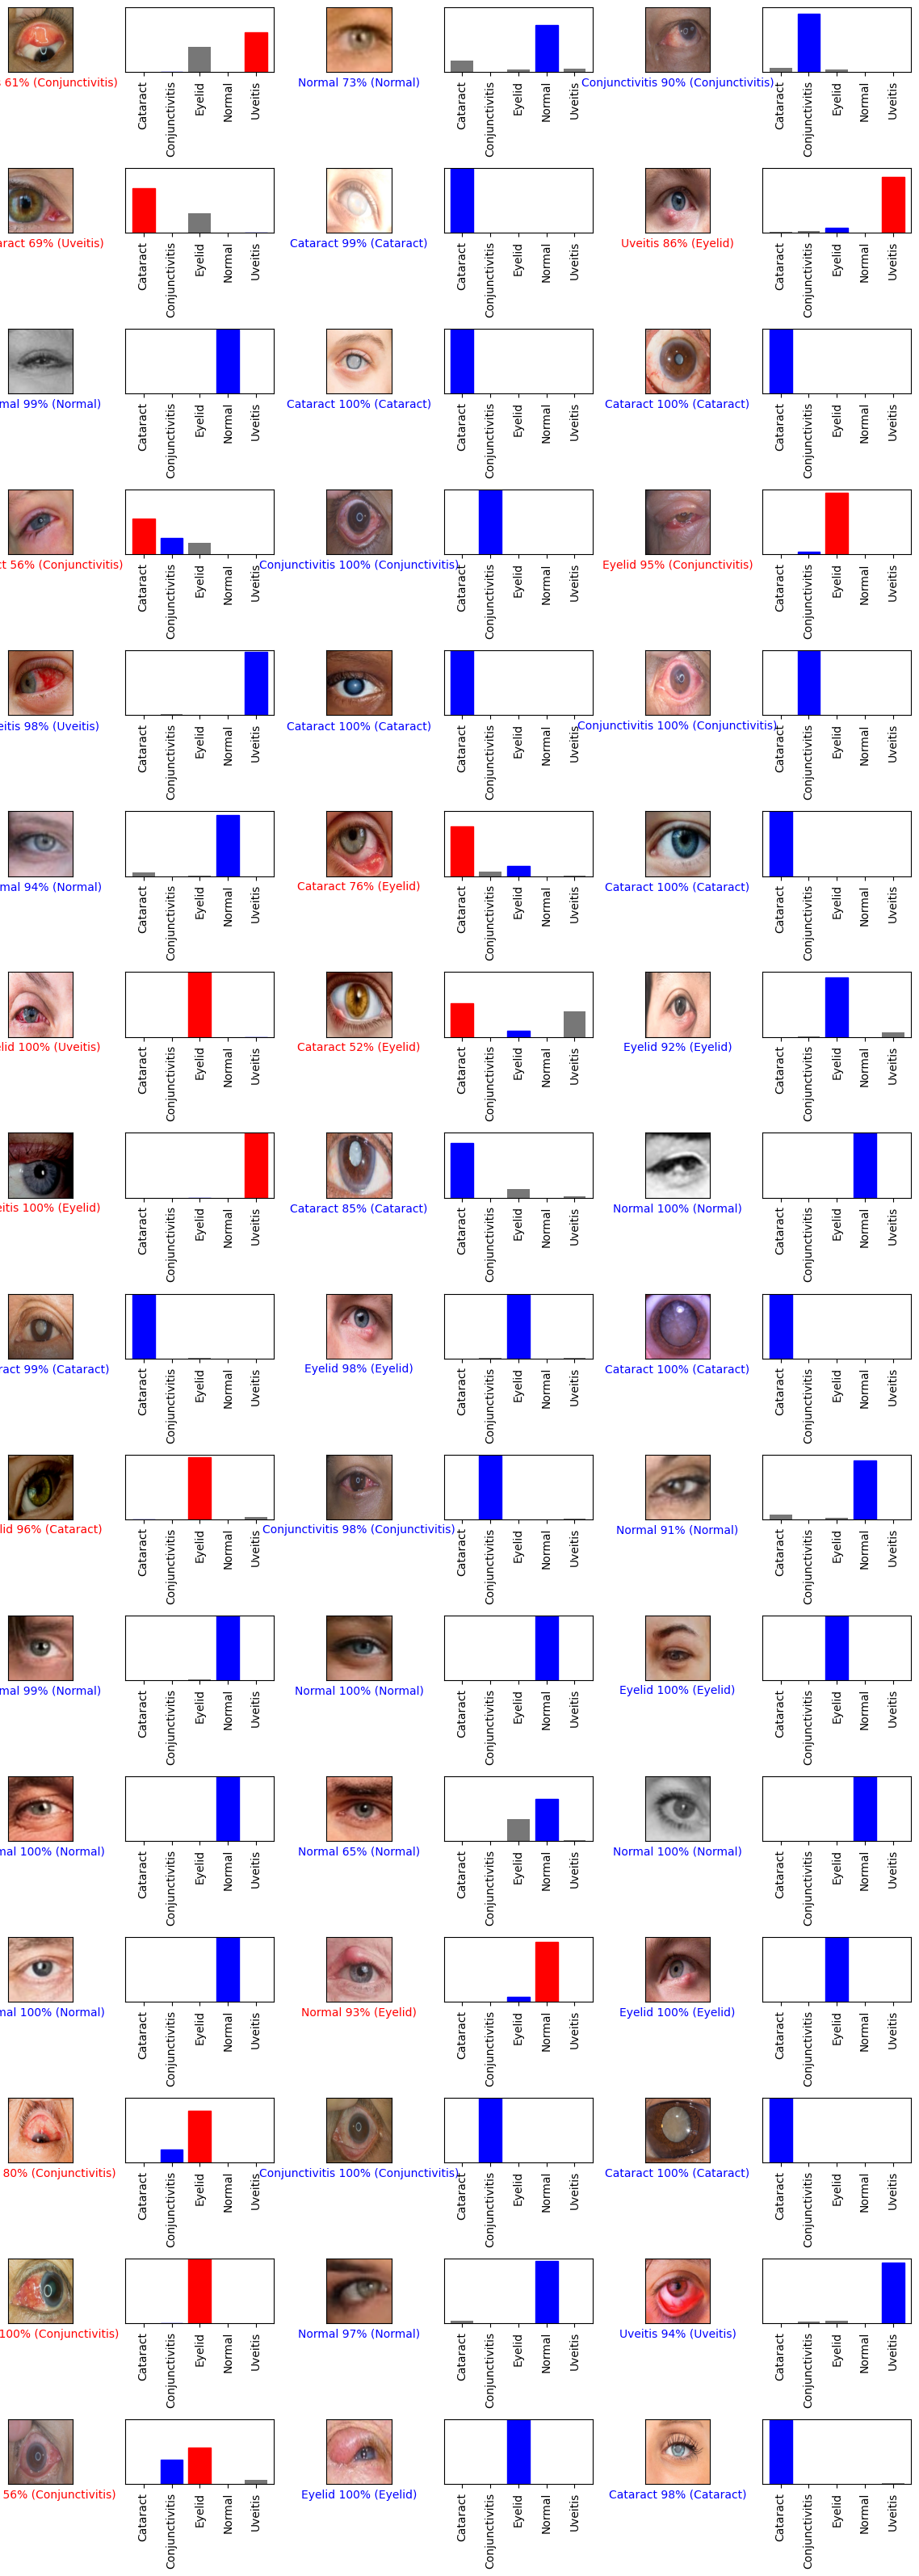

In [13]:
    # Step 10: Show a sample of the test data and results


probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(X_test)
#print(predictions)
#print(X_test)

def plot_image_refactored(predictions_array, true_label, img, class_names):
  try:
    true_label = np.argmax(true_label)
  except (ValueError, TypeError):
    true_label = int(true_label)

  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  color = 'blue' if predicted_label == true_label else 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

# Added class_names as a parameter here as well
def plot_value_array_refactored(predictions_array, true_label, class_names):
  num_classes = len(class_names)

  try:
    true_label = np.argmax(true_label)
  except (ValueError, TypeError):
    true_label = int(true_label)
  class_names = label_encoder.classes_
  plt.grid(False)
  plt.xticks(range(num_classes), class_names, rotation=90)
  plt.yticks([])
  thisplot = plt.bar(range(num_classes), predictions_array, color="#777777")
  plt.ylim([0, 1])

  predicted_label = np.argmax(predictions_array)
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

# The plotting loop
num_rows = 16
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  # FIX: Pass class_names when you call the function
  plot_image_refactored(predictions[i], y_test[i], X_test[i], class_names)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  #print(class_names)
  #plot_value_array_refactored(predictions[i], y_test[i], class_names)
  # FIX: Pass class_names here too
  plot_value_array_refactored(predictions[i], y_test[i], class_names)
plt.tight_layout()
plt.show()

In [14]:
# Step 11: Print the results for the test, trainging and validation

# Get the last value in the list for each metric
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

# The model.evaluate() function returns the loss and accuracy on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

print("--- Training / Validation Results (from final epoch) and Final Test Results ---")
# Print the final accuracy values
print(f"Final Training Accuracy: {final_train_acc:.2%}")
print(f"Final Validation Accuracy: {final_val_acc:.2%}")
print(f"Test Accuracy: {test_acc:.2%}")
print("-" * 50)

# Print the final loss values
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print("\n" + "="*50 + "\n") # Add a major separator



15/15 - 1s - 75ms/step - accuracy: 0.7549 - loss: 1.1305
--- Training / Validation Results (from final epoch) and Final Test Results ---
Final Training Accuracy: 99.27%
Final Validation Accuracy: 75.05%
Test Accuracy: 75.49%
--------------------------------------------------
Final Training Loss: 0.0380
Final Validation Loss: 1.2055
Test Loss: 1.1305


